# ssp.train.py

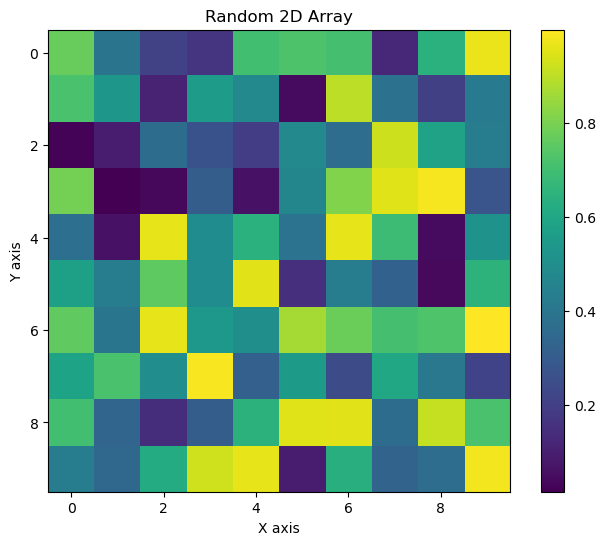

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from snntorch import spikegen


# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = '4',
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    coarse_com_mode = True,
    coarse_com_config = (2.0, -2.0), # (max, min)

    sae_l2_norm_bridge = True,
    sae_lif_bridge = False,

    accuracy_check_epoch_term = 5,
    
    lif_add_at_last = False,

    two_channel_input = False,

    lateral_feature_num = 4,

    lc_adc_on = False, 

    converted_net_forward = False,

    pretrained_net = None, 

    vth_mul_on = False,
    batch_norm_on = False,

    l2_norm_loss_weight = 0.0,
    ):
    if coarse_com_mode == True:
        assert coarse_com_config[0] > coarse_com_config[1], 'coarse_com_config[0] > coarse_com_config[1]이어야 함'
        assert SAE_net == True, 'coarse_com_mode는 SAE_net이 True일 때만 가능'
    if two_channel_input == True:
        assert Conv_net and coarse_com_mode, 'two_channel_input는 Conv_net이 True일 때만 가능'
    if lc_adc_on == True:
        assert coarse_com_mode and SAE_net, 'lc_adc_on은 coarse_com_mode와 SAE_net이 True일 때만 가능'
    if converted_net_forward == True:
        assert SAE_net == False, 'converted_net_forward는 SAE_net이 False일 때만 가능'
    seed_assign(my_seed)
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    # JSON으로 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'w') as f:
        json.dump(hyperparameters, f, indent=4)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")


    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])
    # tem=10
    # cos_thr = np.array([tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, ])

    print('cos_thr', cos_thr)
    
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    if coarse_com_mode == True:
        level_num = TIME
        TIME = spike_length
        spike_length = level_num
        level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num-1)  # max - min
        levels = [coarse_com_config[1] + level_interval * i for i in range(level_num)]
        levels = torch.tensor(levels).to(torch.float).to(device)
        levels = levels.repeat(TIME,1) 
        # print('levels', levels, levels.shape) # TIME, level_num

    n_sample = spike_length

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)


    # vth_mul_on = True # True False
    # batch_norm_on = True # True False


    # 모델 초기화
    if SAE_net == False: # 여기서는 l2norm, lif bridge 둘 다 true면 l2norm먼저
        if Conv_net == True:
            input_channels = 2 if two_channel_input else 1
            net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
                                    batch_norm_on=batch_norm_on).to(device)
            net = torch.nn.DataParallel(net)
            if converted_net_forward:
                converted_net = SAE_converted_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                    synapse_fc_trace_const1=1, 
                                    synapse_fc_trace_const2=v_decay, #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last,
                                    vth_mul_on=vth_mul_on, batch_norm_on=batch_norm_on).to(device) # lif bridge는 무조건 들어가게 해놨음.
                converted_net = torch.nn.DataParallel(converted_net)
                print('converted_net', converted_net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[400, lateral_feature_num], decoder_ch=[400,n_sample], n_sample=n_sample, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
                                    batch_norm_on=batch_norm_on).to(device)
            net = torch.nn.DataParallel(net)
            if converted_net_forward:
                converted_net = SAE_converted_fc(encoder_ch=[400, lateral_feature_num], 
                                    decoder_ch=[400, n_sample], 
                                    in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                    synapse_fc_trace_const1=1,
                                    synapse_fc_trace_const2=v_decay,  #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last,
                                    vth_mul_on=vth_mul_on, batch_norm_on=batch_norm_on).to(device) # lif bridge는 무조건 들어가게 해놨음.
                converted_net = torch.nn.DataParallel(converted_net)
                # print('converted_net', converted_net)
    else: # 여기서는 l2norm, lif bridge 둘 다 true면 lif또는 relu먼저
        if Conv_net == True: 
            input_channels = 2 if two_channel_input else 1
            net = SAE_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last).to(device)
            net = torch.nn.DataParallel(net)
        else:
            net = SAE_fc_only(encoder_ch=[400, lateral_feature_num], 
                                decoder_ch=[400, n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last).to(device)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마
    # net.module.load_state_dict(torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_annbase_20250108_210641_941.pth'))
    if pretrained_net != None:
        net.module.load_state_dict(torch.load(pretrained_net))
        # pre_net = Autoencoder_conv1_old(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge)
        # pre_net = torch.nn.DataParallel(pre_net)
        # pre_net.module.load_state_dict(torch.load(pretrained_net))
        # copy_weights(pre_net.module.encoder , net.module.encoder )
        # copy_weights(pre_net.module.decoder , net.module.decoder  )

        




    wandb.watch(net, log="all", log_freq = 10)





    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__



    net = net.to(device)
    print(f"Total number of encoder parameters: {sum(p.numel() for p in net.module.encoder.parameters())}")
    print(net)
    print('Device:',device)

    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0

    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__
        
    k_means_acc_best = 0
    for epoch in range(max_epoch):
        print()
        l2_loss_bin= 0
        ae_train_start_time = time.time()
        running_loss = 0.0
        iter = 0
        net.train()
        # if True or max_epoch != 1:
        if max_epoch != 1:
            for data in train_loader:
                optimizer.zero_grad()
                data = data.to(device)
                data = zero_to_one_normalize_features(data) if normalize_on else data
                spike_backup = data
                spike = data
                spike = spike.to(device) # batch, feature
                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                    spike = (spike > levels).to(torch.float) 

                    spike = (spike == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike

                    # spike: batch, time, level_num
                    # levels: time, level_num
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        if two_channel_input == True:
                            spike_backup = spike_backup.to(device)
                            spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_backup = (spike_backup <= levels).to(torch.float) 
                            spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                            spike_backup = spike_backup.unsqueeze(-2)
                            spike = torch.cat((spike, spike_backup), dim=-2)
                    assert spike.shape[0] == batch_size and spike.shape[1] == TIME
                elif 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                else:
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) #batch in_channel,feature

                # for i in range (3):
                #     plot_spike(spike[i,:,0,:].cpu().numpy())
                #     plot_spike(spike[i,:,1,:].cpu().numpy())
                # assert False
                        
                # spike_class = net(spike) # batch, time, feature
                encoded_spike = net.module.encoder(spike)
                spike_class = net.module.decoder(encoded_spike)

                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    criterion = nn.MSELoss().to(device)
                    # loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    # loss1 = nn.MSELoss()(spike_class[..., 5:25, :], spike[..., 5:25, :])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5, :], spike[..., 0:5, :])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length, :], spike[..., 25:spike_length, :])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    loss = criterion(spike_class, spike)
                elif 'SAE' in net.module.__class__.__name__:
                    criterion = nn.MSELoss().to(device)
                    loss1 = criterion(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = criterion(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = criterion(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'
                else:

                    criterion = nn.MSELoss().to(device)
                    loss1 = criterion(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = criterion(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = criterion(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'

                    if l2_norm_loss_weight > 0:
                        assert len(encoded_spike.shape) == 2, 'time 성분 없는 걸로'
                        l2_loss = l2_norm_loss(encoded_spike, target_norm=1.0)  # L2Norm Loss 계산, l2 1.0되게.
                        loss = loss + l2_loss*l2_norm_loss_weight
                        l2_loss_bin += l2_loss.item()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                # print(f'\nepoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
                iter += 1
        else:
            print('\n\n\n max_epoch 1이면 Train 안함!!!!!!!!!!!!!!!!!!!!!')
        print('l2_loss_bin', l2_loss_bin/len(train_loader))
        avg_loss = running_loss / len(train_loader)
        assert not np.isnan(avg_loss), f"Error: avg_loss is NaN! Running loss: {running_loss}, Length of train_loader: {len(train_loader)}"
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')
        print(f"ae train 실행 시간: {time.time()-ae_train_start_time:.3f}초, 전체 시작 시간 {current_time}")

        # plot_activation_distribution(net)

        if SAE_net == False and converted_net_forward == True:
            source_encoder = net.module.encoder 
            target_encoder = converted_net.module.encoder  
            copy_weights(source_encoder, target_encoder)

        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    

        k_means_acc = 0
        converted_k_means_acc = 0
        if(epoch % accuracy_check_epoch_term == 0 or epoch == 1 or epoch == max_epoch-1): 
            accuracy_check_start_time = time.time()
            print(f'\nepoch-{epoch} accuracy check')
            k_means_bin_origin_feature = []
            k_means_bin = []
            converted_k_means_bin = []
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                spike_template = torch.from_numpy(spike_template).to(device)
                spike = torch.from_numpy(spike).to(device)
                spike_template = zero_to_one_normalize_features(spike_template) if normalize_on else spike_template
                spike = zero_to_one_normalize_features(spike) if normalize_on else spike
                
                hidden_size = lateral_feature_num*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else lateral_feature_num

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                


                net.eval()
                with torch.no_grad():
                    spike_torch = spike_template.float()
                    spike_torch = spike_torch[:num_cluster]
                    spike_backup = spike_torch
                    spike_torch = spike_torch.to(device)
                    if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_torch = (spike_torch > levels).to(torch.float) 
                        spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                            if two_channel_input == True:
                                spike_backup = spike_backup.to(device)
                                spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                spike_backup = (spike_backup <= levels).to(torch.float) 
                                spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                spike_backup = spike_backup.unsqueeze(-2) # batch, time, in_channel, feature
                                spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                    elif 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    else:
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                        if converted_net_forward == True:
                            spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                    ### forward #######################################################
                    inner_inf = net.module.encoder(spike_torch)
                    if SAE_net == False and converted_net_forward == True:
                        converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                    ### forward #######################################################

                    # for i in range(3):
                    #     plot_spike(spike_torch[i,:,:].cpu().numpy())
                    #     plot_spike(inner_inf[i,:].cpu().numpy())
                    #     plot_spike(net.module.decoder(inner_inf)[i,:,:].cpu().numpy())
                        
                    # if 'SAE' in net.module.__class__.__name__:
                    #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                    #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                    #     print(all_equal, inner_inf)

                    if 'SAE' in net.module.__class__.__name__:
                        if SAE_hidden_nomean == True:
                            inner_inf = inner_inf.reshape(inner_inf.shape[0],-1)# time*feature 펼치기
                        else:
                            inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균

                    Cluster = inner_inf.cpu().detach().numpy()

                encoder_batch = 128
                spike_hidden = np.zeros((len(spike), hidden_size))
                converted_spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    now_index = 0
                    while (1):
                        now_end_index = now_index+encoder_batch if now_index+encoder_batch < len(spike) else len(spike)
                        spike_batch = spike[now_index:now_end_index] 
                        spike_torch = spike_batch
                        spike_torch = spike_torch.float()
                        spike_backup = spike_torch
                        spike_torch = spike_torch.to(device)
                        if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_torch = (spike_torch > levels).to(torch.float) 
                            spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                                if two_channel_input == True:
                                    spike_backup = spike_backup.to(device)
                                    spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                    spike_backup = (spike_backup <= levels).to(torch.float) 
                                    spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                    spike_backup = spike_backup.unsqueeze(-2)
                                    spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                        elif 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        else:
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                            if converted_net_forward == True:
                                spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                                
                        ### forward #######################################################
                        inner_inf = net.module.encoder(spike_torch)
                        if SAE_net == False and converted_net_forward == True:
                            converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                        ### forward #######################################################
                            
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.reshape(spike_batch.shape[0],-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[now_index:now_end_index] = inner_inf.cpu().detach().numpy()
                        if SAE_net == False and converted_net_forward == True:
                            converted_spike_hidden[now_index:now_end_index] = converted_inner_inf.cpu().detach().numpy()
                        now_index += encoder_batch
                        if (now_index >= len(spike)):
                            break
                    
                spike_id = np.zeros(len(spike))
                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                plot_tau = []
                plot_denominator = []
                plot_m = []
                plot_max_tau = []
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                        plot_denominator.append(denominator)
                        if 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                            tau[q] = tau[q] / denominator

                        plot_tau.append(tau[q])

                    # for i in range(num_cluster): # l2 distance
                    #     distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))
                    distance_sm = np.sum(np.power(np.abs(Cluster - spike_hidden[spike_index, :]), 2), axis=1)

                    m = np.argmin(distance_sm)
                    plot_m.append(m)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    plot_max_tau.append(np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16

                origin_kmeans_accuracy = cluster_spikes_with_accuracy(features= spike.cpu().detach().numpy(), true_labels=label-1, n_clusters=3, init_point=None)
                kmeans_accuracy = cluster_spikes_with_accuracy(features= spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                k_means_bin_origin_feature.append(origin_kmeans_accuracy)
                k_means_bin.append(kmeans_accuracy)
                if SAE_net == False and converted_net_forward == True:
                    converted_kmeans_accuracy = cluster_spikes_with_accuracy(features= converted_spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                    converted_k_means_bin.append(converted_kmeans_accuracy)

                # print('Cluster',Cluster)
                # print('spike_id', spike_id)

                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                perm_start_time = time.time() 
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1
                # print(f"perm 실행 시간: {time.time()-perm_start_time:.3f}초")
                
                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]
                # plot_distributions(ds, plot_tau, plot_denominator, plot_m, plot_max_tau, cos_thr[ds],
                #                    cluster_accuracy_during_training_cycle_all_dataset[ds], cluster_accuracy_post_training_cycle_all_dataset[ds], cluster_accuracy_total_all_dataset[ds])
            print(f'k_means origin feature average accuracy : {100*sum(k_means_bin_origin_feature)/(len(k_means_bin_origin_feature)+1e-12):.8f}%, total {k_means_bin_origin_feature}')
            if SAE_net == False and converted_net_forward == True:
                converted_k_means_acc = 100*sum(converted_k_means_bin)/len(converted_k_means_bin)
                print(f'converted_kmeans average accuracy : {converted_k_means_acc:.8f}%, total {converted_k_means_bin}')
            k_means_acc = 100*sum(k_means_bin)/len(k_means_bin)
            if k_means_acc > k_means_acc_best:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
                print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            
            k_means_acc_best = max(k_means_acc_best, k_means_acc)
            print(f'kmeans average accuracy best : {k_means_acc_best:.2f}%, kmeans average accuracy : {k_means_acc:.8f}%, total {k_means_bin}')
            print(f'cluster_accuracy_post_training_cycle_all_dataset : {cluster_accuracy_post_training_cycle_all_dataset}')


            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.8f}%")

            # if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
            #     # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
            #     torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
            #     print('save model')
            #     best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
            print(f"accuracy_check 실행 시간: {time.time()-accuracy_check_start_time:.3f}초")

        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"k_means_acc": k_means_acc})
        wandb.log({"converted_k_means_acc": converted_k_means_acc})


        # 저장
        with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
            pickle.dump({
                "loss_history": loss_history,
                "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
            }, f)















In [3]:

# gpu = '2'
# Conv_net = True # True False
# SAE_net = False # True False

# # hyperparameter
# dataset_num = 16
# spike_length = 50 # coarse_com_mode일 때는 time step이 됨.
# num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
# training_cycle = 2400 #1400 2400 # 그 초기 몇개까지만 cluster update할지


# batch_size = 32
# max_epoch = 7000
# learning_rate = 0.001
# normalize_on = True # True or False # 0부터1까지 normalize
# need_bias = False
# # first_layer_no_train = False
# lif_add_at_first = False
# my_seed = 42

# TIME = 10 # SAE일 때만 유효. coarse_com_mode일 때는 level_num이 됨. 즉 feature 개수.
# v_decay = 1.0 # -cor
# v_threshold = 0.53 # -cor
# v_reset = 0.0 # -cor # 10000 이상 일 시 hard reset
# BPTT_on = True # +cor

# SAE_hidden_nomean = True # True False

# current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

# optimizer = 'SGD' #'Adam', 'SGD' # 둘다 준수함. loss 줄이는 거는 adam이 좋긴한데, cluster accuracy는 비슷함.

# coarse_com_mode = False
# coarse_com_config = (2.0, -2.0) # (max, min) (2.0, -2.0) (3.0 -3.0)

# sae_l2_norm_bridge = True # True False
# sae_lif_bridge = True # False True

# accuracy_check_epoch_term = 1

# lif_add_at_last = False # True False

# two_channel_input = False # True False

# lateral_feature_num = 4

# lc_adc_on = False # True False

# converted_net_forward = False # True False

# pretrained_net = None
# # pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250110_203117_390.pth'
# # pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250113_134126_881_이거 94.43나오는거.pth'

# vth_mul_on = True # True False
# batch_norm_on = False # True False

# l2_norm_loss_weight = 0 #0.1 #  0 # 0초과면 작동

# wandb.init(project= f'spike_sorting just run',save_code=False)


# cluster_train_system( 
#     gpu = gpu,
#     Conv_net = Conv_net,
#     SAE_net = SAE_net,

#     # hyperparameter
#     dataset_num = dataset_num,
#     spike_length = spike_length,
#     num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#     training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#     batch_size = batch_size,
#     max_epoch = max_epoch,
#     learning_rate = learning_rate,
#     normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#     need_bias = need_bias,
#     # first_layer_no_train = False
#     lif_add_at_first = lif_add_at_first,
#     my_seed = my_seed,

#     TIME = TIME, # SAE일 때만 유효
#     v_decay = v_decay,
#     v_threshold = v_threshold,
#     v_reset = v_reset, # 10000이상 일 시 hard reset
#     BPTT_on = BPTT_on,

#     SAE_hidden_nomean = SAE_hidden_nomean,
    
#     current_time = current_time,

#     optimizer = optimizer, #'Adam', 'SGD'

#     coarse_com_mode = coarse_com_mode,
#     coarse_com_config = coarse_com_config, # (max, min)

    
#     sae_l2_norm_bridge = sae_l2_norm_bridge,
#     sae_lif_bridge = sae_lif_bridge,

#     accuracy_check_epoch_term = accuracy_check_epoch_term,
    
#     lif_add_at_last = lif_add_at_last,

#     two_channel_input = two_channel_input,

#     lateral_feature_num = lateral_feature_num,

#     lc_adc_on = lc_adc_on, 

#     converted_net_forward = converted_net_forward,

#     pretrained_net = pretrained_net,

#     vth_mul_on = vth_mul_on,
#     batch_norm_on = batch_norm_on,

#     l2_norm_loss_weight = l2_norm_loss_weight,
#     )



In [4]:
# Sweep code


from unittest import TextTestRunner


unique_name_hyper = 'cluster_train_system'
# run_name = 'spike_sorting'
sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
sweep_configuration = {
    'method': 'bayes', # 'random', 'bayes'
    'name': f'spike_sorting_{sweep_start_time}',
    'metric': {'goal': 'maximize', 'name': 'k_means_acc'},
    'parameters': 
    {
        # "gpu": {"values": ['1']},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
        "Conv_net": {"values": [True]}, 
        "SAE_net": {"values": [False]}, 

        "dataset_num": {"values": [16]}, 
        "spike_length": {"values": [50]},  
        "num_cluster": {"values": [4]}, 
        "training_cycle": {"values": [2400]}, # [1400, 2400]

        "batch_size": {"values": [32]}, 
        "max_epoch": {"values": [20]}, 
        "learning_rate": {"values": [0.001]},
        "normalize_on": {"values": [True]},
        "need_bias": {"values": [True, False]}, # [True, False]

        "lif_add_at_first": {"values": [False]}, # [True, False]
        "my_seed": {"values": [42]}, 

        "TIME": {"values": [10]}, #  [4,6,8,10]
        "v_decay": {"values": [1.0]}, # [0.25,0.50,0.75]
        "v_threshold": {"values": [0.125]}, # [0.25,0.50,0.75]
        "v_reset": {"values": [0.0]},  # [0.0, 10000.0]
        "BPTT_on": {"values": [True]},  # [True, False]

        "SAE_hidden_nomean": {"values": [True]}, # [True, False]

        # "current_time": {"values": [current_time]} #밑에서 직접설정됨.

        "optimizer": {"values": ['SGD']}, # ['Adam', 'SGD']

        "coarse_com_mode": {"values": [False]}, # [True, False]
        "coarse_com_config": {"values": [(2.0, -2.0)]}, # ['Adam', 'SGD']

        "sae_l2_norm_bridge": {"values": [False]}, # [True, False]
        "sae_lif_bridge": {"values": [True]}, # [False, True]
        
        "accuracy_check_epoch_term": {"values": [1]}, 

        "lif_add_at_last": {"values": [False]},# [True, False]

        "two_channel_input": {"values": [False]},# [True, False]

        "lateral_feature_num": {"values": [4]},# [True, False]

        "lc_adc_on": {"values": [False]},# [True, False]
        
        "converted_net_forward": {"values": [False]},# [True, False]

        "pretrained_net": {"values": [None]},# [None]

        "vth_mul_on": {"values": [True]},# [True, False]
        "batch_norm_on": {"values": [False]},# [True, False]

        "l2_norm_loss_weight": {"min": 0.0001, "max": 0.5},
     }
}


def hyper_iter():
    ### my_snn control board ########################
    wandb.init(save_code = False)
    gpu  =  '4'
    Conv_net  =  wandb.config.Conv_net
    SAE_net  =  wandb.config.SAE_net

    dataset_num  =  wandb.config.dataset_num
    spike_length  =  wandb.config.spike_length
    num_cluster  =  wandb.config.num_cluster
    training_cycle  =  wandb.config.training_cycle

    batch_size  =  wandb.config.batch_size
    max_epoch  =  wandb.config.max_epoch
    learning_rate  =  wandb.config.learning_rate
    normalize_on  =  wandb.config.normalize_on
    need_bias  =  wandb.config.need_bias

    lif_add_at_first  =  wandb.config.lif_add_at_first
    my_seed  =  wandb.config.my_seed


    TIME  =  wandb.config.TIME
    v_decay  =  wandb.config.v_decay
    v_threshold  =  wandb.config.v_threshold
    v_reset  =  wandb.config.v_reset
    BPTT_on  =  wandb.config.BPTT_on

    SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
    current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

    optimizer  =  wandb.config.optimizer

    coarse_com_mode = wandb.config.coarse_com_mode
    coarse_com_config = wandb.config.coarse_com_config # (max, min)

    sae_l2_norm_bridge = wandb.config.sae_l2_norm_bridge
    sae_lif_bridge = wandb.config.sae_lif_bridge

    accuracy_check_epoch_term = wandb.config.accuracy_check_epoch_term

    lif_add_at_last = wandb.config.lif_add_at_last

    two_channel_input = wandb.config.two_channel_input

    lateral_feature_num = wandb.config.lateral_feature_num

    lc_adc_on = wandb.config.lc_adc_on

    converted_net_forward = wandb.config.converted_net_forward

    pretrained_net = wandb.config.pretrained_net

    vth_mul_on = wandb.config.vth_mul_on
    batch_norm_on = wandb.config.batch_norm_on

    l2_norm_loss_weight = wandb.config.l2_norm_loss_weight

    cluster_train_system( 
        gpu = gpu,
        Conv_net = Conv_net,
        SAE_net = SAE_net,

        # hyperparameter
        dataset_num = dataset_num,
        spike_length = spike_length,
        num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
        training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


        batch_size = batch_size,
        max_epoch = max_epoch,
        learning_rate = learning_rate,
        normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
        need_bias = need_bias,
        # first_layer_no_train = False
        lif_add_at_first = lif_add_at_first,
        my_seed = my_seed,

        TIME = TIME, # SAE일 때만 유효
        v_decay = v_decay,
        v_threshold = v_threshold,
        v_reset = v_reset, # 10000이상 일 시 hard reset
        BPTT_on = BPTT_on,

        SAE_hidden_nomean = SAE_hidden_nomean,

        current_time = current_time,

        optimizer = optimizer, #'Adam', 'SGD'

        coarse_com_mode = coarse_com_mode,
        coarse_com_config = coarse_com_config, # (max, min)
        
        sae_l2_norm_bridge = sae_l2_norm_bridge,
        sae_lif_bridge = sae_lif_bridge,

        accuracy_check_epoch_term = accuracy_check_epoch_term,

        lif_add_at_last = lif_add_at_last,
        
        two_channel_input = two_channel_input,
        
        lateral_feature_num = lateral_feature_num,

        lc_adc_on = lc_adc_on,

        converted_net_forward = converted_net_forward,

        pretrained_net = pretrained_net,

        vth_mul_on = vth_mul_on,
        batch_norm_on = batch_norm_on,

        l2_norm_loss_weight = l2_norm_loss_weight,
        )
    
# sweep_id = 'ygoj9jt4'
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: vkaortef
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/spike_sorting%20cluster_train_system/sweeps/vkaortef


wandb: Agent Starting Run: c1k99ofk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.23586277957767685
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_190254_059', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.23586277957767685, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: 73rav7f6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.06885198882497887
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_191136_780', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.06885198882497887, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: y8t1yksa with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.22707654800912577
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_191949_673', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.22707654800912577, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 6n3pvbd8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2432827246030227
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_192859_163', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2432827246030227, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: etn5t20r with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.10869886859792878
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_193803_957', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.10869886859792878, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: swz4x1el with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.1850812273242576
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_194614_494', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.1850812273242576, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: as6n05ic with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.017135821154807104
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_195453_670', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.017135821154807104, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Agent Starting Run: ka2clk5l with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.09038142805203042
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_200305_063', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.09038142805203042, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 7eqmw8cv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4127069546772313
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_201218_370', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4127069546772313, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: eec0xdrh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.19936564595784656
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_202045_741', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.19936564595784656, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: inm71782 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3727911788899698
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_202951_945', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3727911788899698, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: dh5hiksj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3504451998060209
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_203828_346', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3504451998060209, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: s57265ei with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.11685958363095948
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_204715_112', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.11685958363095948, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: xrh8slzr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.20133805714474257
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_205614_385', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.20133805714474257, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: lay8ksai with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.12766414077296856
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_210449_018', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.12766414077296856, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kz4plb5n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3508481621199442
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_211305_601', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3508481621199442, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: xtukvd2u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3846106720128492
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_212139_269', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3846106720128492, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: zk4kr3ze with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.16476102740653242
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_213043_743', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.16476102740653242, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l3ub0bx6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2147416443447541
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_213950_530', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2147416443447541, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k9rfhyfa with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.11621561812222785
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_214900_905', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.11621561812222785, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: t3e5rw10 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.35063083183548627
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_215721_999', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.35063083183548627, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: rzepj5ex with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3950302294246736
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_220554_864', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3950302294246736, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: nzd15of0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.33380088530677143
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_221434_683', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.33380088530677143, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: khng03dz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.12915845757622457
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_222344_535', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.12915845757622457, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: bzqok8kw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.31729637482472417
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_223214_710', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.31729637482472417, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: f9zno5lh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.16018461953148144
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_224049_376', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.16018461953148144, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: 3pmyfusd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4942466473594013
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_224923_763', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4942466473594013, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 2zie6uje with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.43698480830529907
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_225828_933', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.43698480830529907, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: qw2jzwvv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4152200007151923
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_230721_822', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4152200007151923, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: nhdxi9pf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.37630175995983217
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_231611_535', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.37630175995983217, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9obgj873 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.15238340418734136
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_232504_875', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.15238340418734136, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: f01n0qxd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4585472335220451
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_233425_456', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4585472335220451, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: 536rrlun with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.45214937297681734
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_234258_520', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.45214937297681734, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yrpjr1wd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.04073448784061517
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_235153_241', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.04073448784061517, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: 80i7m0fi with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.038740735568786704
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to d

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_000011_249', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.038740735568786704, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Agent Starting Run: rdu73rkk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2210013683840399
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_000827_766', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2210013683840399, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: jh7ise3k with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.0476676700886976
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_001737_060', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.0476676700886976, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rewhr8d4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3963706534424033
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_002707_174', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3963706534424033, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 8nts9r94 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.29546941686057326
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_003612_817', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.29546941686057326, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v3euieb4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.35455149744492964
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_004501_224', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.35455149744492964, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: e9qc35t7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.16846726569373718
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_005359_997', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.16846726569373718, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: ehar0grl with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4168789646935039
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_010241_606', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4168789646935039, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: svq9aa8i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.07285968602066817
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_011226_988', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.07285968602066817, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xabg2q7a with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.06730955703769548
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_012055_186', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.06730955703769548, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: lscvp2hr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.18548180386229715
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_012911_252', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.18548180386229715, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l6drdb3a with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.09726558440429056
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_013756_770', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.09726558440429056, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: jkd3qu9n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2019678143929085
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_014651_559', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2019678143929085, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 9hi99r72 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2623491938856779
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_015609_065', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2623491938856779, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: sax6bcq8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.24880080380303635
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_020542_246', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.24880080380303635, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: e2dem6qf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4705213230691788
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_021409_059', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4705213230691788, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: jn2nhi9y with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.41725604299891134
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_022315_409', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.41725604299891134, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: ns9cupri with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3612503888451813
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_023220_789', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3612503888451813, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: eumc8i2j with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.02476673085279863
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_024105_245', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.02476673085279863, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: qndjwesk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.22979968813252064
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_025027_598', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.22979968813252064, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: ktv7v61f with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.1012429863784843
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_025950_544', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.1012429863784843, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 6lkob3cz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.11896052268955866
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_030922_222', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.11896052268955866, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: uscsjjzp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.10388413319968748
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_031750_370', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.10388413319968748, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 08sejcy5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.05281404657768277
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_032619_614', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.05281404657768277, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: j1eom6xo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3487372976538943
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_033436_160', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3487372976538943, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: q9g4q5bv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.264515209498293
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to detec

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_034324_704', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.264515209498293, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
  

wandb: Agent Starting Run: o4rn8j8h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.49782246816334874
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_035245_153', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.49782246816334874, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: r0ncx31h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4031344858468902
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_040134_786', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4031344858468902, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 62wilzbc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.07181863217278203
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_041030_286', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.07181863217278203, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: tryr9wis with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.34654715678819337
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_041953_376', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.34654715678819337, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: pvf97cpn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.40695822045292535
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_042825_856', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.40695822045292535, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: fiu6m78e with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3992431407861354
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_043705_590', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3992431407861354, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: xnlinm0m with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.023587447387290413
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to d

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_044551_265', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.023587447387290413, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ii0cohow with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3694095363503874
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_045414_033', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3694095363503874, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mdgabl4h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.060939862012273895
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_050255_832', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.060939862012273895, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Agent Starting Run: 7a05cjah with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4986667350907315
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_051116_400', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4986667350907315, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: dn6rccj9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3992958641239646
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_052019_710', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3992958641239646, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gwkivndl with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.08353442400167815
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_052907_349', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.08353442400167815, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: 8e7ux8wf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3718556483352905
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_053731_080', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3718556483352905, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: vm5z8mh1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4062440727556896
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_054639_159', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4062440727556896, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: ntwtxmdb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.06799110156540725
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_055523_825', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.06799110156540725, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: 1759vn4m with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2422226860277482
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_060342_520', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2422226860277482, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: crctajlz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2603804912641403
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_061211_757', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2603804912641403, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t8unnigp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3165595956877593
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_062138_607', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3165595956877593, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: 23alw3vc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.08753208868640351
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_063015_417', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.08753208868640351, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: lck1w3sg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.06840288578048183
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_063937_934', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.06840288578048183, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: jm3wavrx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.01149392785199059
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_064753_176', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.01149392785199059, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: qlrrv53x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.33869017353380476
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_065612_881', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.33869017353380476, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dx9vfapq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.01107968555370074
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_070508_530', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.01107968555370074, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 09x6pmxo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.08323708215790414
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_071337_481', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.08323708215790414, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: l9jlq629 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.13386746241713823
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_072155_092', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.13386746241713823, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: n1bova8x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.050539226713884375
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to d

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_073014_632', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.050539226713884375, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Agent Starting Run: 8tbcppg7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3526602034490768
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_073837_233', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3526602034490768, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: brs0ben1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.06939017101076254
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_074745_304', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.06939017101076254, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: m06wfspo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3609417226180409
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_075607_927', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3609417226180409, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 6t86ncpk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3528554569897732
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_080508_519', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3528554569897732, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: r41kog3n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2294940167661988
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_081358_132', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2294940167661988, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: msgh0hxs with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.41605425037947535
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_082243_370', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.41605425037947535, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: kgt37f7p with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.41718701994641777
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_083131_963', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.41718701994641777, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: 4sinu6rt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.23112553687154824
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_084016_320', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.23112553687154824, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gfmhb1e9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.08745170874305752
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_084859_083', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.08745170874305752, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: ajqk6waw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2357005069768813
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_085825_818', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2357005069768813, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: e4bqgzuj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.35598196516980224
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_090649_452', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.35598196516980224, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: lculc2xd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.29061784551697323
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_091540_070', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.29061784551697323, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: q9n2b5a8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.08927125754952937
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_092424_427', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.08927125754952937, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: tgl1m9m2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.47367796933472034
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_093352_898', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.47367796933472034, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: fxjj9y5l with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.32645637358409846
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_094253_705', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.32645637358409846, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: bg14nhvo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.11285692048904948
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_095143_828', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.11285692048904948, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: c06854io with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.1156606952480354
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_100042_295', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.1156606952480354, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: cdxdu5kw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3560621114494896
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_100926_294', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3560621114494896, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: q4ghwenn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.41277887564124977
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_101824_292', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.41277887564124977, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 3q48wldx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3352170182112921
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_102716_473', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3352170182112921, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: g09uwbhk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.20254221192886315
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_103556_782', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.20254221192886315, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 271uccj8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.19761512708122567
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_104507_132', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.19761512708122567, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lifc9p4h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.49384517261168226
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_105405_794', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.49384517261168226, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: nhumqmsg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.32164762126332724
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_110257_710', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.32164762126332724, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: sz7d0utw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.14896437755855974
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_111130_841', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.14896437755855974, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: izdwk3d7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.260480698282846
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_112038_066', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.260480698282846, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(
 

wandb: Agent Starting Run: b1ltkobu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3752752560469312
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_112906_809', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3752752560469312, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s899mzj2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.24240529086800483
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_113807_743', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.24240529086800483, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 9kcmvi3s with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3290755128468274
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_114736_036', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3290755128468274, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 6xc0tf0w with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3802852897251464
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_115700_683', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3802852897251464, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: go9ups5f with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.013121346225516035
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_120610_539', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.013121346225516035, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(

wandb: Agent Starting Run: 0fbtkmng with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4021919852211186
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_121509_041', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4021919852211186, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: 4uqmdg2s with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3649195299184634
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_122406_560', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3649195299184634, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: x49hjitg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.20174959949287144
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_123306_603', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.20174959949287144, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: zain20fy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.09951835349431867
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_124144_739', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.09951835349431867, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: ljhwjctv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.455465224304302
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to detec

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_125001_230', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.455465224304302, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
  

wandb: Agent Starting Run: 8nzv8eeg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.22449919277560348
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_125854_969', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.22449919277560348, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: bkspsfaq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.016690400974032422
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to d

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_130803_631', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.016690400974032422, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Agent Starting Run: o43l3lgs with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.04258612731894842
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_131622_297', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.04258612731894842, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mr700sfd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3028831437648129
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_132454_886', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3028831437648129, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 4w3qpwus with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.2585372282594067
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_133454_953', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.2585372282594067, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: 9twk3lpu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.06719735232173268
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_134417_523', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.06719735232173268, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 3yb13qkc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.10412760757115508
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_135347_931', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.10412760757115508, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: 4ls1y8pq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3724788450442717
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_140226_603', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3724788450442717, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m5wzs77p with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4835353534587889
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_141140_359', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4835353534587889, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: vemzd9ce with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.31558798266026
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to detec

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_142052_062', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.31558798266026, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(
  

wandb: Agent Starting Run: lp4q19cx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.08891209965845503
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_142945_004', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.08891209965845503, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 7gqwcpg2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.04884112274477583
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_143919_101', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.04884112274477583, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: x64rsofy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.11422550493478092
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_144851_042', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.11422550493478092, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: i9co1njx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3369092262527542
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_145801_557', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3369092262527542, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: laoztent with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.14567480930651114
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_150715_087', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.14567480930651114, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 0mary7p1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3208522226595949
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_151649_781', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3208522226595949, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: f3qewkh3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.400315200289315
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_152626_822', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.400315200289315, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(
 

wandb: Agent Starting Run: 0w8b5s32 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4038112507432242
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_153522_994', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4038112507432242, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ro5esps2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.005864803003090981
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_154426_208', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.005864803003090981, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(

wandb: Agent Starting Run: ti6au5ao with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.015207871169972178
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to d

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_155409_427', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.015207871169972178, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Agent Starting Run: 0i8h4ieo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.15399009465126978
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_160242_307', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.15399009465126978, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: x1gg7z7c with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.4743157952331275
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_161203_222', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.4743157952331275, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: 614yd8c4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.47081118965694974
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_162132_780', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.47081118965694974, 'coarse_com_config': [2, -2]}


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(
  (module): Autoencoder_conv1(
    (encoder): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (3): ReLU()
      (4): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (5): ReLU()
      (6): SSBH_DimChanger_for_fc()
      (7): Linear(in_features=480, out_features=4, bias=False)
      (8): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=480, bias=False)
      (1): ReLU()
      (2): SSBH_DimChanger_for_conv1()
      (3): ConvTranspose1d(96, 64, kernel_size=(3,), stride=(2,), bias=False)
      (4): ReLU()
      (5): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), output_padding=(1,), bias=False)
      (6): ReLU()
      (7): ConvTransp

wandb: Agent Starting Run: vs9851m4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.030344715151296792
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to d

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_163050_335', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.030344715151296792, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: Agent Starting Run: hioeb530 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.44555507592363675
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_164009_361', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.44555507592363675, 'coarse_com_config': [2, -2]}


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
  (module): Autoencoder_conv1(
    (encoder): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
      (3): ReLU()
      (4): Conv1d(64, 96, kernel_size=(3,), stride=(2,))
      (5): ReLU()
      (6): SSBH_DimChanger_for_fc()
      (7): Linear(in_features=480, out_features=4, bias=True)
      (8): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=480, bias=True)
      (1): ReLU()
      (2): SSBH_DimChanger_for_conv1()
      (3): ConvTranspose1d(96, 64, kernel_size=(3,), stride=(2,))
      (4): ReLU()
      (5): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), output_padding=(1,))
      (6): ReLU()
      (7): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(2,), output_padding=(1,

wandb: Agent Starting Run: 7jq78wqd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.02990293604109419
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_164927_254', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.02990293604109419, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 31dlbi53 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.28847843975860954
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_165901_722', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.28847843975860954, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: 02t1r2br with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.13908712971890563
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_170834_123', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.13908712971890563, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Agent Starting Run: xodcrddb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.23889053082321957
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_171723_955', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.23889053082321957, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5kal0ban with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.08214581213039376
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb:

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_172707_509', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.08214581213039376, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x176jos7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.034374795230464356
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_173554_431', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.034374795230464356, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
save model
kmeans average accuracy best : 84.80%, kmeans average accuracy : 84.79888409%, total [0.9701195219123506, 0.9724588302101079, 0.9695139488064424, 0.9513529073114565, 0.9524926686217009, 0.909375, 0.8097332160656698, 0.7073170731707317, 0.9340821755838014, 0.8207656612529002, 0.7030529953917051, 0.6303456356180434, 0.9351961950059453, 0.865684575389948, 0.7566860465116279, 0.6796450042943029]
cluster_accuracy_post_training_cycle_all_dataset : [0.97396768 0.97326203 0.96657382 0.94040968 0.96435644 0.89910714
 0.80316518 0.68561279 0.88504578 0.8129771  0.71455224 0.36489152
 0.72614108 0.8220339  0.74

wandb: Network error (ReadTimeout), entering retry loop.


k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
kmeans average accuracy best : 84.80%, kmeans average accuracy : 84.76993586%, total [0.9701195219123506, 0.9724588302101079, 0.9695139488064424, 0.9513529073114565, 0.9527859237536657, 0.9110795454545455, 0.810905892700088, 0.7041973908111174, 0.9326041974578776, 0.8213457076566125, 0.699020737327189, 0.627709431751611, 0.9343043995243757, 0.8682842287694974, 0.7587209302325582, 0.6787861437160034]
cluster_accuracy_post_training_cycle_all_dataset : [0.97396768 0.97326203 0.96657382 0.94040968 0.96435644 0.90089286
 0.80118694 0.69360568 0.89216684 0.69561069 0.7136194  0.37771203
 0.69813278 0.76082863 0.74230

wandb: Agent Starting Run: m5xltq4j with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.3186231607868568
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to dete

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_174434_253', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.3186231607868568, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(
 

wandb: Agent Starting Run: dn8dvf7k with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.1129847347354576
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_175355_246', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.1129847347354576, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(


wandb: Agent Starting Run: amk13jer with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.12344554939686292
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to det

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_180228_382', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.12344554939686292, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3eoe6f63 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.33870583949783656
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_181211_307', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.33870583949783656, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26788
DataParallel(


wandb: Agent Starting Run: nvvjiiul with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	l2_norm_loss_weight: 0.46524235682453785
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 20
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
wandb: 	vth_mul_on: True
Failed to de

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '4', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 20, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250116_182053_895', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': True, 'batch_norm_on': False, 'l2_norm_loss_weight': 0.46524235682453785, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(

In [ ]:
wandb.finish() 

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# import pickle
# import json

# # current_time = '20250102_225243_972'

# with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
#     data = pickle.load(f)


# # JSON으로 저장
# with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'r') as f:
#     loaded_hyperparameters = json.load(f)

# loss_history = data['loss_history']
# mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
# mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
# mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']
# print(data)
# max_acc = 0
# for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
#     if i[1] > max_acc:
#         max_acc = i[1]

# # 설정 정보 제목 작성
# title = (
#     f"Dataset Num: {loaded_hyperparameters['dataset_num']}, Conv {loaded_hyperparameters['Conv_net']}, SAE {loaded_hyperparameters['SAE_net']}, Current time {loaded_hyperparameters['current_time']}, Spike Length: {loaded_hyperparameters['spike_length']}, Num Cluster: {loaded_hyperparameters['num_cluster']}, "
#     f"Training Cycle: {loaded_hyperparameters['training_cycle']}, Batch Size: {loaded_hyperparameters['batch_size']}, Max Epoch: {loaded_hyperparameters['max_epoch']}, \n"
#     f"Learning Rate: {loaded_hyperparameters['learning_rate']}, Input Normalize: {loaded_hyperparameters['normalize_on']}, Need Bias: {loaded_hyperparameters['need_bias']}, "
#     f"LIF Add at First: {loaded_hyperparameters['lif_add_at_first']}, TIME: {loaded_hyperparameters['TIME']}, Seed: {loaded_hyperparameters['my_seed']}, Best ACC: {max_acc:.2f}%"
# )

# # 데이터 리스트와 라벨 설정 (Loss 제외)
# data_list = [
#     ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
# ]

# # 플롯 생성
# fig, ax1 = plt.subplots(figsize=(12, 8))

# # 첫 번째 y축: Accuracy 관련 데이터
# for label, data in data_list:
#     epochs, values = zip(*data)  # epoch, value 분리
#     ax1.plot(epochs, values, label=label)

# ax1.set_xlabel("Epoch")
# ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")
# ax1.legend(loc="center right")
# ax1.grid(True)

# # x축을 정수만 표시하도록 설정
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# # 두 번째 y축: Loss History
# ax2 = ax1.twinx()
# epochs, values = zip(*loss_history)
# ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
# ax2.set_ylabel("Loss", color="red")
# ax2.tick_params(axis="y", labelcolor="red")
# ax2.legend(loc="center left")

# # 제목 추가
# plt.title(title, fontsize=10)
# plt.tight_layout()
# plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
# plt.show()


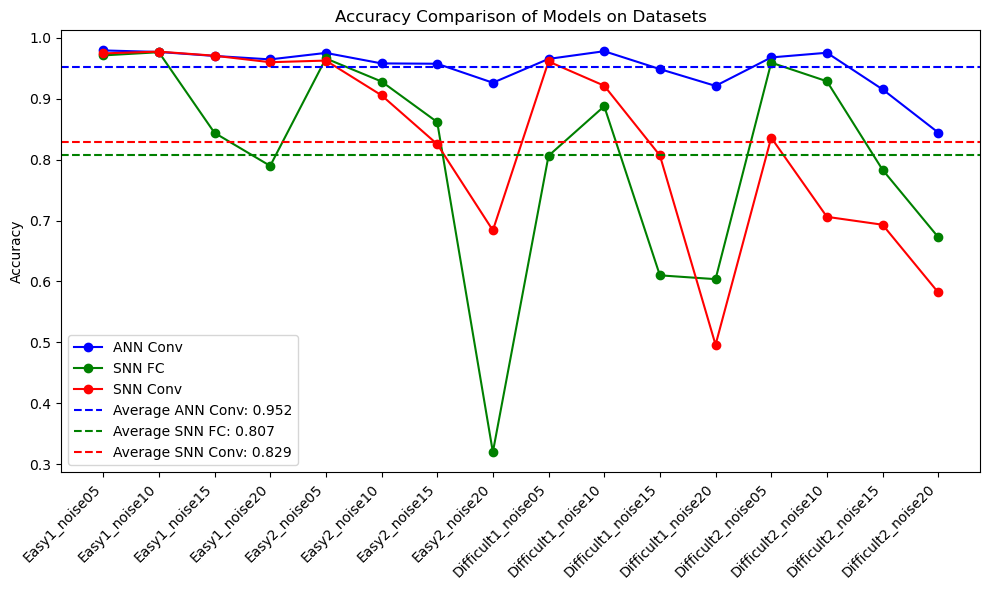

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋
filename_for_plot = [
    "Easy1_noise05", "Easy1_noise10", "Easy1_noise15", "Easy1_noise20",
    "Easy2_noise05", "Easy2_noise10", "Easy2_noise15", "Easy2_noise20",
    "Difficult1_noise05", "Difficult1_noise10", "Difficult1_noise15", "Difficult1_noise20",
    "Difficult2_noise05", "Difficult2_noise10", "Difficult2_noise15", "Difficult2_noise20"
]

# Accuracy 데이터
ANN_conv_accracy_set= [0.97935368, 0.97682709, 0.97028784, 0.96461825, 0.97524752, 0.95803571
, 0.95746785, 0.92628774, 0.965412,  0.97805344, 0.94869403, 0.92110454
, 0.96784232, 0.97551789, 0.91538462, 0.84446478]
SNN_fc_accuracy_set = [0.97114475, 0.97643732, 0.84400578, 0.78977821, 0.96616915, 0.92830189
, 0.86176032, 0.31984948, 0.80635401, 0.88769531, 0.61003861, 0.60377358
, 0.9592668,  0.92870999, 0.78333333, 0.67271859]
SNN_conv_accuracy_set = [0.97445601, 0.97737983, 0.97063072, 0.95998071, 0.96268657, 0.90566038
, 0.82545997, 0.68391345, 0.96116994, 0.92138672, 0.80694981, 0.49602781
, 0.83604888, 0.70611057, 0.69313725, 0.5819398 ]

# 평균 계산
average_ANN_conv = np.mean(ANN_conv_accracy_set)
average_SNN_fc = np.mean(SNN_fc_accuracy_set)
average_SNN_conv = np.mean(SNN_conv_accuracy_set)

# 데이터 준비
accuracies = np.array([ANN_conv_accracy_set, SNN_fc_accuracy_set, SNN_conv_accuracy_set])
averages = np.array([average_ANN_conv, average_SNN_fc, average_SNN_conv])

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델의 정확도 플롯
ax.plot(accuracies[0], label='ANN Conv', marker='o', linestyle='-', color='blue')
ax.plot(accuracies[1], label='SNN FC', marker='o', linestyle='-', color='green')
ax.plot(accuracies[2], label='SNN Conv', marker='o', linestyle='-', color='red')

# 평균값 플롯
ax.axhline(y=average_ANN_conv, color='blue', linestyle='--', label=f'Average ANN Conv: {average_ANN_conv:.3f}')
ax.axhline(y=average_SNN_fc, color='green', linestyle='--', label=f'Average SNN FC: {average_SNN_fc:.3f}')
ax.axhline(y=average_SNN_conv, color='red', linestyle='--', label=f'Average SNN Conv: {average_SNN_conv:.3f}')

# 레이블 추가
ax.set_xticks(np.arange(len(filename_for_plot)))
ax.set_xticklabels(filename_for_plot, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Models on Datasets')
ax.legend()

plt.tight_layout()
plt.show()


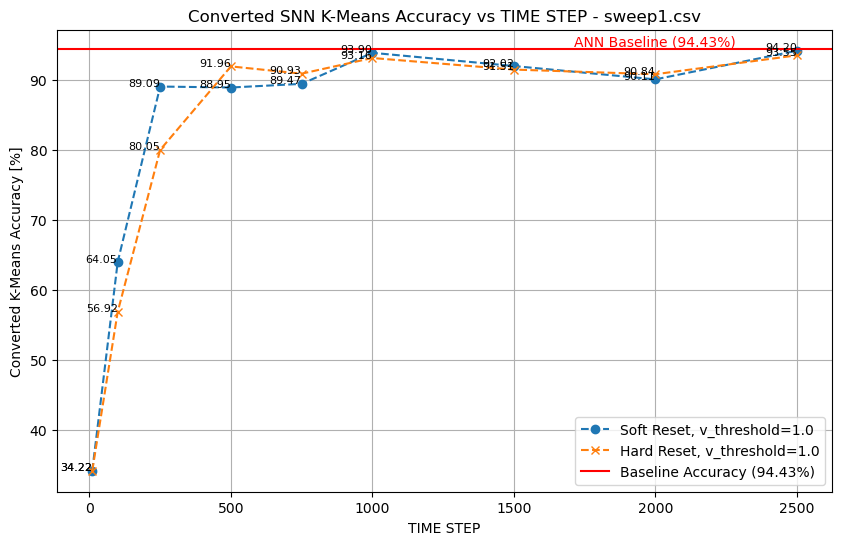

In [ ]:
import csv
import matplotlib.pyplot as plt
import os  # 파일 경로 처리를 위한 모듈

# CSV 파일 경로
# csv_file_path = "/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/ae_test_deprecated/250115/sweep0_vth_mul.csv" # vth_mul해서 sweep 돌린거
csv_file_path = "/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/ae_test_deprecated/250115/sweep1.csv"  #vth_mul안한거

# 결과를 저장할 리스트
tuple_list = []

# CSV 파일 읽기
with open(csv_file_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            # v_threshold, TIME, v_reset, converted_k_means_acc 값을 가져와 튜플로 변환
            v_threshold = float(row["v_threshold"])
            time = int(row["TIME"])
            v_reset = int(row["v_reset"])
            converted_k_means_acc = float(row["converted_k_means_acc"]) if row["converted_k_means_acc"] else None

            # 튜플 형태로 추가 (값이 None일 경우 처리할 수도 있음)
            tuple_list.append((v_threshold, time, v_reset, converted_k_means_acc))
        except ValueError as e:
            print(f"Error processing row {row}: {e}")

# 데이터를 TIME 기준으로 정렬
tuple_list.sort(key=lambda x: x[1])  # TIME을 기준으로 오름차순 정렬

# reset 방식에 따라 데이터를 나누기
soft_reset = [t for t in tuple_list if t[2] == 0]
hard_reset = [t for t in tuple_list if t[2] == 10000]

# reset 방식과 v_threshold에 따라 색상 설정
def plot_data(data, label_prefix, marker):
    for v_threshold in [1.0]:  # v_threshold 기준으로 제한
        filtered_data = [(t[1], t[3]) for t in data if t[0] == v_threshold]
        if filtered_data:  # 해당 v_threshold 데이터가 있을 경우만 플롯
            times, accuracies = zip(*filtered_data)  # x축(TIME), y축(converted_k_means_acc)
            
            plt.plot(
                times,
                accuracies,
                marker,
                label=f"{label_prefix}, v_threshold={v_threshold}",
                linestyle="--",
            )
            # 각 점에 accuracy 표시
            for time, acc in filtered_data:
                if acc == None:
                    continue
                plt.text(time, acc, f"{acc:.2f}", fontsize=8, ha="right")

# 그래프 초기화
plt.figure(figsize=(10, 6))

# soft_reset (v_reset=0) 데이터 플롯
plot_data(soft_reset, "Soft Reset", "o")

# hard_reset (v_reset=10000) 데이터 플롯
plot_data(hard_reset, "Hard Reset", "x")

# baseline accuracy 가로선 추가
baseline_accuracy = 94.43
plt.axhline(y=baseline_accuracy, color="red", linestyle="-", label=f"Baseline Accuracy ({baseline_accuracy}%)")
# baseline 텍스트 추가
plt.text(
    2000,  # x축 위치 (그래프 오른쪽 끝)
    baseline_accuracy + 0.4,  # y축 위치 (baseline 위 약간)
    f"ANN Baseline ({baseline_accuracy}%)",
    color="red",
    fontsize=10,
    ha="center",
)

# CSV 파일 이름 가져오기
csv_file_name = os.path.basename(csv_file_path)

# 그래프 세부 설정
plt.title(f"Converted SNN K-Means Accuracy vs TIME STEP - {csv_file_name}")
plt.xlabel("TIME STEP")
plt.ylabel("Converted K-Means Accuracy [%]")
plt.legend(loc="lower right")  # 범례를 오른쪽 아래로 이동
plt.grid(True)

# 그래프 출력
plt.show()
